# Shape Detection
The following Notebook intends to take a look at the detection of a variable number of bounding boxes that delimit objects in an image dataset. The structure of this experiment is as follows:

* Premise
* Dataset generation
* Dataset Analysis and preprocessing
* Modeling Training phase
* Prediction analysis
* Conclusions

## Premise

(tags: CNN, Object detection)

This work was inspired by [Johannes Rieke article on Medium](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) and by [Andrew Ng's Specialization Course on Deep Learning](https://www.coursera.org/specializations/deep-learning).

Rieke's work is interesting for the simplicity with which he creates a trainingset for our purpose - that is, developing bounding boxes that identify particular objects in an image. I dedicate myself in particular to the identification of several objects in the same image.

Rieke highlights a big risk: in the identification of N objects, the neural network ends up with not specializing and instead it develops 'average' bounding boxes - more or less equal - useless for our purpose. To solve this problem he proposes an algorithm for swapping the example's targets label between one epoch and another. A mechanism that did not convince me for two reasons:

- it considerably weighs the algorithm on a computational level (at the end of epoch the predictions of the network with the target values are compared).
- in the tests I did I could not get out of a sort of perpetual oscillation and at every epoch the percentage of swaps remained almost unchanged.

Conceptually starting from the work of Rieke I propose a solution that makes clear the importance of a preprocessing of our dataset. In fact, I create an order in the target values of our trainingset. I take as reference point the distance from one of the edges of the image (the origin in a coordinate system). 

As you can see it is an elegant solution that solves the problem upstream. Later I dedicate myself to improving the efficiency of the neural network.



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from keras import optimizers
import pickle
from sd_utils.py import * 

%matplotlib inline

## Dataset Generation
We create a simple image dataset. Each image will have a maximum size of 32x32 and will contain up to a maximum of N_bb objects (rectangles) with different shades of color. Their size will vary between a minimum of 1x1 and a maximum of 8x8. [To implement : If the color gradation (0-255) is less than or greater than a certain threshold (in our case <64), the object must not be detected.]

At the same time we define our bounding boxes. We will use 5 coordinates: a 'Pc', which indicates the percentage of confidence in the presence of an object; 'x' and 'y', for the spatial position of the top-left vertex and 'w' and 'h' for the extension (width and height).

In [0]:
N_imgs = 100000

# imagines side dimension
side_dim = 32 

# objects min/max side dimensions
obj_min_dim = 2
obj_max_dim = 8 

# number of objects
N_bb = 4 

# color thresholds
min_threshold = 0
max_threshold = 124

# confidence threshold
Pc_th = .0

# inizialization of images with a light gray color (just for aesthetic reasons)
imgs = np.ones((N_imgs, side_dim, side_dim,3)) * .9 

# inizialization of bounding boxes
bounding_boxes = np.zeros((N_imgs, N_bb, 5))

# inizialization of origin distance array
distance = np.zeros((N_imgs, N_bb))

In [0]:
# creation of images, Bounding Boxes and an origin distance to order BB
imgs, bounding_boxes, distance = create_dataset(N_imgs, N_bb, side_dim, obj_min_dim, obj_max_dim, min_threshold, max_threshold)

## Dataset Analysis and Preprocessing
First we analyze our datasets and start preprocessing them

In [6]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)

Dimension of images array: (100000, 32, 32, 3)
Dimension of BBoxes array: (100000, 4, 5)
Dimension of distance array: (100000, 4)


Imagine n. 23644


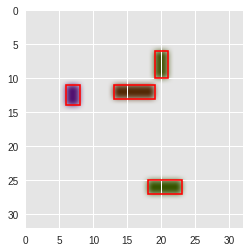

In [7]:
# We take a random image of our training set
im = np.random.randint(N_imgs)
print('Imagine n.', im)

# Let's look the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgs[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the corresponding bounding boxes
for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

# we consider only a percentage of confidence above the Pc_th
# (in our datasets we have Pc with values 0 or 1) but later
# Pc will assume probabilistic values between 0 and 1
  if Pc >= Pc_th:
    rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.6', fc='none')
    ax.add_patch(rect)

plt.show()

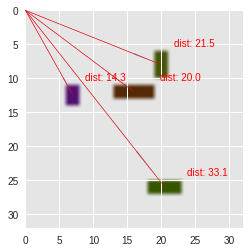

In [8]:
# We look at the image again, this time highlighting the distance of the objects from the origin ...
fig, ax = plt.subplots(1)

ax.imshow(imgs[im], origin = 'upper', interpolation = 'hanning', extent=[0, side_dim, side_dim, 0])

for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

  if Pc >= Pc_th:
    line = patches.Arrow(0, 0, x+(w/2), y+(h/2), .2, ec='r') 
    ax.add_patch(line)
    dida = 'dist: ' + '{:0.1f}'.format(distance[im,i])
    plt.annotate(dida, (x + w + 0.8 , y - 0.8), color='r')

plt.show()


We rearrange the bounding boxes based on the distance from the origin of the objects to avoid the problem highlighted by Rieke's article.

In [0]:
bb_ordered = order_bb(bounding_boxes, distance) 

Let's start thinking in terms of Machine Learning.  <br/>
So we normalize the pixel values contained in our images to have values between -1 and 1 and transfer them to the input X values.

In [9]:
X = (imgs - np.mean(imgs)) / np.std(imgs)
print('X shape: ',X.shape, '---- Average value: ', np.mean(imgs), '---- Standard deviation:', np.std(imgs))

Y = bb_ordered.reshape(N_imgs, -1) 
print('Y shape: ',Y.shape)

X shape:  (100000, 32, 32, 3) ---- Average value:  0.8498243504774303 ---- Standard deviation: 0.1790191150896044
Y shape:  (100000, 20)


Below we see the shape of our X values and we observe one of our Y target values.

In [0]:
print('Images example', i, 'has shape:\n', X[im].shape, '\n')
print('...and the target values Y are:\n', Y[im])

We have a homogeneous dataset of the N_imgs elements that we now share in Training set, Validation set, and Test set in relation 60%, 20%, 20%.

In [16]:
i = int(0.6 * N_imgs)
j = int(0.2 * N_imgs)

X_train = X[:i]
Y_train = Y[:i]
train_ex = X_train.shape[0]

X_val = X[i:i+j]
Y_val = Y[i:i+j]
val_ex = X_val.shape[0]

X_test = X[i+j:]
Y_test = Y[i+j:]
test_ex = X_test.shape[0]

dim_test = j # useful for the future 

print('Below the dimensions of X and Y for Training set, Validation set, and Test set respectively\n')
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

Below the dimensions of X and Y for Training set, Validation set, and Test set respectively

(60000, 32, 32, 3) (60000, 20) (20000, 32, 32, 3) (20000, 20) (20000, 32, 32, 3) (20000, 20)


## Modeling Training phase
###The Neural Network
In previous experiments, we used the network proposed in Rieke's experiment, following the fundamental suggestion of Andrew Ng to implement a model as soon as possible to have a starting point on which to base himself. Now let's start working on network tuning and try to improve its rather poor performance. The model we use is clearly inspired by the [AlexNet](https://en.wikipedia.org/wiki/AlexNet). It uses three pairs of CNN-MaxPooling layers followed, two other  CNN and two fully connected layers, for a total of about 807 thousand parameters.

In [13]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(8, 8), strides=2, padding='same', activation='relu', input_shape=(side_dim,side_dim,3), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(4, 4), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(384, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(384, activation='relu'))
model.add(Dropout(.1))
model.add(BatchNormalization())
model.add(Dense(Y.shape[-1]))

summ = model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 48)        9264      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         98432     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 192)         98496     
__________

As optimization algorithm we use Adadelta, and as loss function we will try Euclidean Distance and Root Mean Squared Error.

Let's start with a cycle of N_ep epochs:

In [0]:
N_ep = 50
init_ep = 0 
Batchs = 128
optimizer = 'adadelta'
loss = rmse # euc_loss

In [17]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 60000 samples, validate on 20000 samples
Epoch 1/50
60000/60000 [==============================] - 24s 403us/step - loss: 3.2039 - val_loss: 2.0039
Epoch 2/50
60000/60000 [==============================] - 19s 310us/step - loss: 1.8710 - val_loss: 1.7280
Epoch 3/50
60000/60000 [==============================] - 19s 310us/step - loss: 1.6502 - val_loss: 1.5756
Epoch 4/50
60000/60000 [==============================] - 19s 318us/step - loss: 1.5062 - val_loss: 1.4773
Epoch 5/50
60000/60000 [==============================] - 19s 319us/step - loss: 1.4089 - val_loss: 1.3246
Epoch 6/50
60000/60000 [==============================] - 19s 319us/step - loss: 1.3245 - val_loss: 1.2511
Epoch 7/50
60000/60000 [==============================] - 19s 317us/step - loss: 1.2608 - val_loss: 1.2478
Epoch 8/50
60000/60000 [==============================] - 19s 316us/step - loss: 1.2063 - val_loss: 1.1876
Epoch 9/50
60000/60000 [==============================] - 19s 315us/step - loss: 1.1654 - val_

##Prediction Analysis
We evaluate the results obtained. We use the Test Set for predictions and define a metric, the IoU (Intersection over Union) that supports those we already have for the training phase - the loss error.

The Intersection over Union is an incredibly effective measure to understand how much our forecasts approach the correct bounding boxes of the objects in the images. It has values that oscillate between 0 and 1 and the closer they are to 1, the more the area of our predictions approaches that of the correct bounding boxes.

But first let's take a look at our predictions.

In [0]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

In [22]:
# And the expected bboxes of our Test set
expe_bboxes = np.float32(Y_test.reshape(dim_test, N_bb, -1))

# Their dimension
pred_bboxes.shape, expe_bboxes.shape

((20000, 4, 5), (20000, 4, 5))

Test images: 5973
Object 1 confidence: 1.0148603
----------> B-box IoU: 35.6% <----------
B-box coordinates: [8.9 15.2 3.4 6.5]
Object coordinates: [10.0 14.0 4.0 7.0]
Object 2 confidence: 0.9933963
----------> B-box IoU: 88.1% <----------
B-box coordinates: [17.0 6.9 5.5 7.0]
Object coordinates: [17.0 7.0 6.0 7.0]
Object 3 confidence: 1.0161597
----------> B-box IoU: 67.6% <----------
B-box coordinates: [19.9 3.4 5.3 6.4]
Object coordinates: [20.0 2.0 5.0 7.0]
Object 4 confidence: 1.0168614
----------> B-box IoU: 14.1% <----------
B-box coordinates: [7.3 29.1 2.3 2.5]
Object coordinates: [9.0 29.0 2.0 2.0]


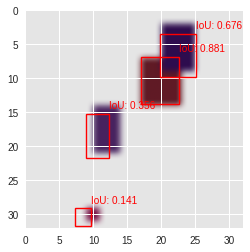

In [23]:
imgTest = (np.reshape(X_test, (dim_test, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Consider a random image of our Test set
im = np.random.randint(dim_test)

# We look at the objects contained in it and the bounding boxes predicted by the algorithm
print('Test images:', im)
visual_example(imgTest[im], side_dim, N_bb, pred_bboxes[im], expe_bboxes[im])

### Evaluation of results
Now we evaluate the results, by calculating the average IoU for predictions on our Test set. 
The graph below shows the learning curve (Euclidean Distance Loss for training and validation sets) for fifty epochs, with a network of 60 thousand examples using 128 mini-batch size.

----> Datatset IoU: 54.894983%
      Dim. train: 60000 examples
      Epochs: 50 - mini-batches: 128


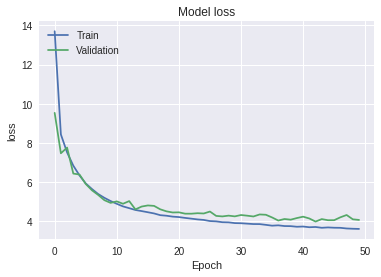

In [29]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, history.history, 'loss')

Below the same network with the same training set, only changing the loss function: we use now Root Mean Square Error (Rmse).

----> Datatset IoU: 55.775815%
      Dim. train: 60000 examples
      Epochs: 50 - mini-batches: 128


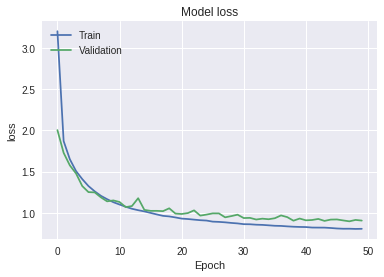

In [24]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, history.history, 'loss')

The new error function provides better results, not only the IoU of the Test set improves by almost one point, but also the trend of our curves shows a smaller deviation between the loss of the training set and the validation set.

Let's try to go on with the training for another 25 epochs.

In [0]:
vl = history.history['val_loss']
tl = history.history['loss']

In [0]:
N_ep = 75
init_ep = 50 
Batchs = 128
optimizer = 'adadelta'
loss = rmse # euc_los

In [27]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 60000 samples, validate on 20000 samples
Epoch 51/75
60000/60000 [==============================] - 20s 327us/step - loss: 0.8001 - val_loss: 0.8838
Epoch 52/75
60000/60000 [==============================] - 18s 294us/step - loss: 0.7959 - val_loss: 0.9022
Epoch 53/75
60000/60000 [==============================] - 18s 299us/step - loss: 0.7985 - val_loss: 0.8997
Epoch 54/75
60000/60000 [==============================] - 18s 293us/step - loss: 0.7913 - val_loss: 0.9016
Epoch 55/75
60000/60000 [==============================] - 18s 292us/step - loss: 0.7919 - val_loss: 0.8828
Epoch 56/75
60000/60000 [==============================] - 17s 289us/step - loss: 0.7934 - val_loss: 0.8993
Epoch 57/75
60000/60000 [==============================] - 17s 291us/step - loss: 0.7867 - val_loss: 0.9023
Epoch 58/75
60000/60000 [==============================] - 18s 293us/step - loss: 0.7839 - val_loss: 0.8832
Epoch 59/75
60000/60000 [==============================] - 18s 293us/step - loss: 0.78

In [0]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

----> Datatset IoU: 57.535059%
      Dim. train: 60000 examples
      Epochs: 75 - mini-batches: 128


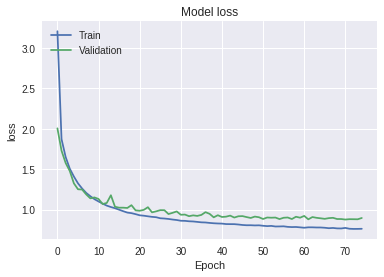

In [30]:
vl += history.history['val_loss']
tl += history.history['loss']
hist = {'val_loss': vl, 'loss': tl}
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, hist, 'loss')

The algorithm continues to learn, our overall IoU reaches over 57 points. 

And even if only slightly, the errors measured by the loss function continue to fall. Let's go on for another 25 times.

In [0]:
N_ep = 100
init_ep = 75 
Batchs = 128
optimizer = 'adadelta'
loss = rmse # euc_los

In [32]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 60000 samples, validate on 20000 samples
Epoch 76/100
60000/60000 [==============================] - 20s 328us/step - loss: 0.7580 - val_loss: 0.8769
Epoch 77/100
60000/60000 [==============================] - 18s 298us/step - loss: 0.7602 - val_loss: 0.8838
Epoch 78/100
60000/60000 [==============================] - 18s 298us/step - loss: 0.7594 - val_loss: 0.8718
Epoch 79/100
60000/60000 [==============================] - 18s 295us/step - loss: 0.7578 - val_loss: 0.8763
Epoch 80/100
60000/60000 [==============================] - 18s 297us/step - loss: 0.7514 - val_loss: 0.8727
Epoch 81/100
60000/60000 [==============================] - 18s 297us/step - loss: 0.7560 - val_loss: 0.9070
Epoch 82/100
60000/60000 [==============================] - 18s 296us/step - loss: 0.7544 - val_loss: 0.8796
Epoch 83/100
60000/60000 [==============================] - 18s 296us/step - loss: 0.7526 - val_loss: 0.8757
Epoch 84/100
60000/60000 [==============================] - 18s 298us/step - l

In [0]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

----> Datatset IoU: 57.675936%
      Dim. train: 60000 examples
      Epochs: 100 - mini-batches: 128


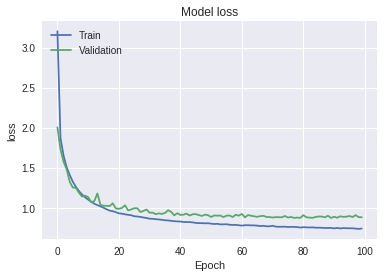

In [34]:
vl += history.history['val_loss']
tl += history.history['loss']
hist = {'val_loss': vl, 'loss': tl}
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, hist, 'loss')

## Some conclusion
With some tricks we have greatly improved the performance of our model. First of all, we have increased the depth of the network by taking inspiration from [AlexNet](https://en.wikipedia.org/wiki/AlexNet). Secondly, we tried two different metrics for our loss function (Euclidean distance and Root Mean Squared Error) and finally opted for Rmse. The global set-point IoU has exceeded 57 points after 75 epochs, but has not been shown to improve a lot more further over the next 25 epochs.